# Testing the correlation between the homicide-rate of a country and general fairness of players originating from that country

### Import the necessary moduls

In [1]:
try:
    import pymongo
    from pymongo import MongoClient
    import folium
    import pandas as pd
    import wget
    import json
    import matplotlib.pyplot as plt
    import matplotlib.style as style
    import seaborn as sns
    from PIL import Image
    import requests
    from io import BytesIO
    from IPython.display import display
except ImportError:
    !pip install pymongo
    import pymongo
    from pymongo import MongoClient
    !pip install folium
    import folium
    !pip install pandas
    import pandas as pd
    !pip install wget
    import wget
    wget.download('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json', 'world-countries.json')
    import json
    !pip install matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.style as style
    !pip install seaborn
    import seaborn as sns
    !pip install PIL
    from PIL import Image
    !pip install requests
    import requests
    !pip install io
    from io import BytesIO
    !pip install IPython.display
    from IPython.display import display

## create the database connection and store the relevant date in dataframes

In [2]:
client = MongoClient("mongodb://pt-n20.p4001.w3.cs.technikum-wien.at:4001")
db = client["criminalSoccer"]

#Client for the homicide data
collection = db["countries"]
cursor = collection.find({})
cursor = collection.find({}, {"_id": 0})  # exclude _id field
data = [doc for doc in cursor]
df = pd.DataFrame(data)

#harmonize the country-names
df["country"] = df["country"].replace({"United States": "United States of America",
                                       "Serbia": "Republic of Serbia",
                                       "North Macedonia": "Macedonia"})



#client for the foul statistics
collection_players = db["players"]
cursor = collection_players.find({})
data_players = [doc for doc in cursor]
df_players = pd.DataFrame(data_players)

#harmonize the country-names
df_players["nationality"] = df_players["nationality"].replace({"United States": "United States of America",
                                                               "Serbia": "Republic of Serbia",
                                                               "North Macedonia": "Macedonia"})

display(df.head(), df_players.head())

,country,count_p_100k
0,Afghanistan,6.7
1,Albania,2.1
2,Algeria,1.3
3,Andorra,2.6
4,Angola,4.8


,_id,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,cross_accuracy,...,nationality,fouls_committed,fouls_suffered,red,yellow,balls_recoverd,clearance_attempted,t_lost,t_won,tackles
0,644b8ed8f7fb1e526a4dd719,Courtois,Real Madrid,Goalkeeper,1230,13,0,0,64.2,0.0,...,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,644b8ed8f7fb1e526a4dd71a,Vinícius Júnior,Real Madrid,Forward,1199,13,4,6,133.0,31.0,...,Brazil,13.0,24.0,1.0,0.0,29.0,0.0,8.0,3.0,11.0
2,644b8ed8f7fb1e526a4dd71b,Benzema,Real Madrid,Forward,1106,12,15,1,121.5,20.0,...,France,2.0,4.0,1.0,0.0,6.0,10.0,0.0,1.0,1.0
3,644b8ed8f7fb1e526a4dd71c,Modrić,Real Madrid,Midfielder,1077,13,0,4,124.5,25.0,...,Croatia,3.0,8.0,1.0,0.0,39.0,4.0,6.0,3.0,9.0
4,644b8ed8f7fb1e526a4dd71d,Éder Militão,Real Madrid,Defender,1076,12,0,0,110.4,0.0,...,Brazil,17.0,16.0,4.0,0.0,76.0,32.0,13.0,6.0,19.0


## General overview of the homicide-data

,count_p_100k
count,195.000000
mean,6.845128
std,9.600060
min,0.000000
25%,1.100000
50%,2.600000
75%,7.850000
max,49.300000


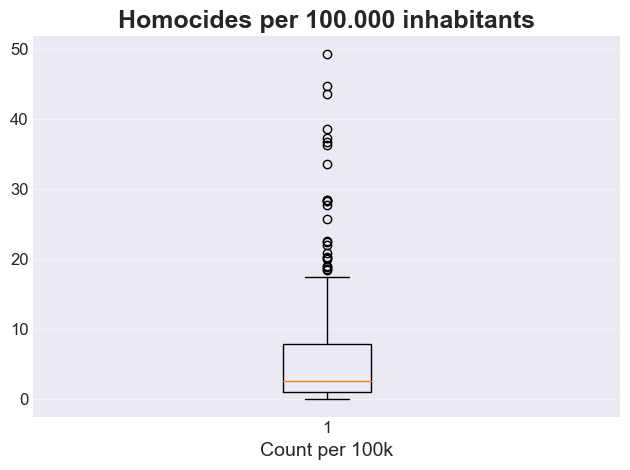

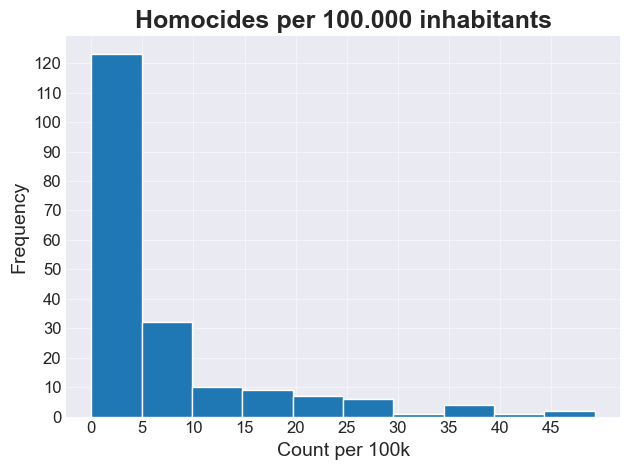

In [3]:
display(df.describe())

style.use('seaborn-v0_8-dark')

# create the boxplot
plt.boxplot(df['count_p_100k'])

# add a title and axis labels
plt.title("Homocides per 100.000 inhabitants", fontsize=18, fontweight='bold')
plt.xlabel("Count per 100k", fontsize=14)

# adjust tick font size
plt.tick_params(axis="both", which="major", labelsize=12)

# add gridlines
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()


# set the style to seaborn-v0_8-dark
style.use('seaborn-v0_8-dark')

# create the histogram with 10 bins
plt.hist(df['count_p_100k'], bins=10, color='#008fd5', edgecolor='white')

# set the x-axis labels to display in 5s
plt.xticks(range(0, int(max(df['count_p_100k']))+1, 5))

# set the y-axis labels to display in 10s
plt.yticks(range(0, int(max(plt.hist(df['count_p_100k'], bins=10)[0]))+1, 10))

# add a title and axis labels
plt.title("Homocides per 100.000 inhabitants", fontsize=18, fontweight='bold')
plt.xlabel("Count per 100k", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# adjust tick font size
plt.tick_params(axis="both", which="major", labelsize=12)

# add gridlines
plt.grid(axis='both', alpha=0.5)

plt.tight_layout()
plt.show()

## Visualise the homicide-data on the world map

In [9]:
m = folium.Map(location=[0, 0], zoom_start=2)

# Add the choropleth layer
choropleth = folium.Choropleth(
    geo_data='world-countries.json',
    name='choropleth',
    data=df.to_dict('split')['data'],
    columns=['country', 'count_p_100k'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Homocide-rate per 100.000 inhabitants',
    bins=100
).add_to(m)

# Load the original GeoJSON data
with open('world-countries.json') as file:
    geojson_data = json.load(file)

# Create a dictionary with country names as keys and homicide rates as values
country_dict = df.set_index('country')['count_p_100k'].to_dict()

# Function to get the homicide rate for a given country
def get_homicide_rate(country_name):
    return country_dict.get(country_name, 'N/A')

# Create GeoJson layer for popups
popup_layer = folium.GeoJson(
    data=geojson_data,
    name='Popups',
    style_function=lambda feature: {
        'fillColor': '#00000000',
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0
    }
)

# Add custom popups with country name and homicide rate to the popup layer
for feature in geojson_data['features']:
    country_name = feature['properties']['name']
    homicide_rate = get_homicide_rate(country_name)
    popup = folium.Popup(f"{country_name}: {homicide_rate} homocides per 100k")
    folium.GeoJson(
        data=feature,
        style_function=lambda feature: {
            'fillColor': '#00000000',
            'color': 'black',
            'weight': 0.3,
            'fillOpacity': 0
        },
        popup=popup
    ).add_to(popup_layer)

popup_layer.add_to(m)

# Add the layer control
folium.LayerControl().add_to(m)

# Show the map
m



## Perform data aggregation and cleansing on player data

In [5]:
data_agg = pd.DataFrame({
    "Country": df["country"],
    "homicide rate": df["count_p_100k"],
    "count of player": 0,
    "fouls committed": 0,
    "minutes played": 0,
    "yellow card received": 0,
    "red card received": 0
})

uk_countries = {
    "England": "United Kingdom",
    "Scotland": "United Kingdom",
    "Wales": "United Kingdom"
}

# aggregate data by country and player
for _, player in df_players.iterrows():
    if player["position"] != "Goalkeeper":
        player_nationality = player["nationality"]
        # Map the nationality to United Kingdom if it's England, Scotland, or Wales
        if player_nationality in uk_countries:
            player_nationality = uk_countries[player_nationality]

        country_mask = data_agg["Country"] == player_nationality
        idx = data_agg.loc[country_mask].index
        if not idx.empty:
            data_agg.loc[idx, "count of player"] += 1
            data_agg.loc[idx, "fouls committed"] += player["fouls_committed"] if pd.notna(player["fouls_committed"]) else 0
            data_agg.loc[idx, "minutes played"] += player["minutes_played"]
            data_agg.loc[idx, "yellow card received"] += player["yellow"] if pd.notna(player["yellow"]) else 0
            data_agg.loc[idx, "red card received"] += player["red"] if pd.notna(player["red"]) else 0


data_agg["fouls per minute"] = data_agg["fouls committed"] / data_agg["minutes played"]
data_agg["yellow per minute"] = data_agg["yellow card received"] / data_agg["minutes played"]
data_agg["red per minute"] = data_agg["red card received"] / data_agg["minutes played"]


display(data_agg.head())


,Country,homicide rate,count of player,fouls committed,minutes played,yellow card received,red card received,fouls per minute,yellow per minute,red per minute
0,Afghanistan,6.7,0,0,0,0,0,NaN,NaN,NaN
1,Albania,2.1,1,3,260,0,0,0.011538,0.0,0.000000
2,Algeria,1.3,4,19,1811,0,4,0.010491,0.0,0.002209
3,Andorra,2.6,0,0,0,0,0,NaN,NaN,NaN
4,Angola,4.8,1,7,528,0,1,0.013258,0.0,0.001894


## Visualise the fouls per minuted played on the world map

In [10]:
# Filter out rows with NaN values in the 'fouls per minute' column
data_agg_filtered = data_agg.dropna(subset=['fouls per minute'])

# Convert the DataFrame data into a dictionary with country names as keys and fouls per minute as values
fouls_dict = data_agg_filtered.set_index('Country')['fouls per minute'].to_dict()

m = folium.Map(location=[0, 0], zoom_start=2)

# Add the choropleth layer
choropleth = folium.Choropleth(
    geo_data='world-countries.json',
    name='choropleth',
    data=data_agg_filtered,
    columns=['Country', 'fouls per minute'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Fouls per minute',
    bins=100
).add_to(m)

# Function to get the fouls per minute for a given country
def get_fouls_per_minute(country_name):
    return fouls_dict.get(country_name, 'N/A')

# Create GeoJson layer for popups
popup_layer = folium.GeoJson(
    data=geojson_data,
    name='Popups',
    style_function=lambda feature: {
        'fillColor': '#00000000',
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0
    }
)

# Add custom popups with country name and fouls per minute to the popup layer
for feature in geojson_data['features']:
    country_name = feature['properties']['name']
    fouls_per_minute = get_fouls_per_minute(country_name)
    popup = folium.Popup(f"{country_name}: {fouls_per_minute} fouls per minute")
    folium.GeoJson(
        data=feature,
        style_function=lambda feature: {
            'fillColor': '#00000000',
            'color': 'black',
            'weight': 0.3,
            'fillOpacity': 0
        },
        popup=popup
    ).add_to(popup_layer)

popup_layer.add_to(m)

# Add the layer control
folium.LayerControl().add_to(m)

# Show the map
m



In [7]:
# sort the data frame by the red cards received per minute column in descending order
df_sorted = df_players.sort_values(by=['red'], ascending=False)

# get the top 10 players with the most red cards received per minute
for i in range(10):
    player_name = df_sorted.iloc[i]['player_name']
    red_cards = df_sorted.iloc[i]['red']
    nationality = df_sorted.iloc[i]['nationality']
    player_icon_url = df_sorted.iloc[i]['icon']

    # download the player's icon as bytes
    response = requests.get(player_icon_url)
    icon_bytes = BytesIO(response.content)

    # open the icon as an image and display the name, red cards, and icon
    player_icon = Image.open(icon_bytes)
    display(player_icon)
    print(f"#{i+1} Player name: {player_name}")
    print(f"Red cards: {red_cards:.0f}")
    print(f"Nationality: {nationality}\n")


#1 Player name: Ikoné
Red cards: 4
Nationality: France



#2 Player name: Éder Militão
Red cards: 4
Nationality: Brazil



#3 Player name: Álvarez
Red cards: 4
Nationality: Argentina



#4 Player name: Adams
Red cards: 4
Nationality: Scotland



#5 Player name: Balanta
Red cards: 4
Nationality: Colombia



#6 Player name: Guilavogui
Red cards: 4
Nationality: France



#7 Player name: Paredes
Red cards: 3
Nationality: Argentina



#8 Player name: Jesus
Red cards: 3
Nationality: Brazil



#9 Player name: Milner
Red cards: 3
Nationality: England



#10 Player name: Matheus Nunes
Red cards: 3
Nationality: Portugal



## Correlation testing

testing the homicide rate against
- fouls per minute
- fouls
- yellow card received per minute
- red card received per minute

Correlation between homicide rate and fouls per minute: 0.09296
Correlation between homicide rate and fouls: -0.06414
Correlation between homicide rate and yellow cards per minute: -0.03647
Correlation between homicide rate and red cards per minute: -0.05104


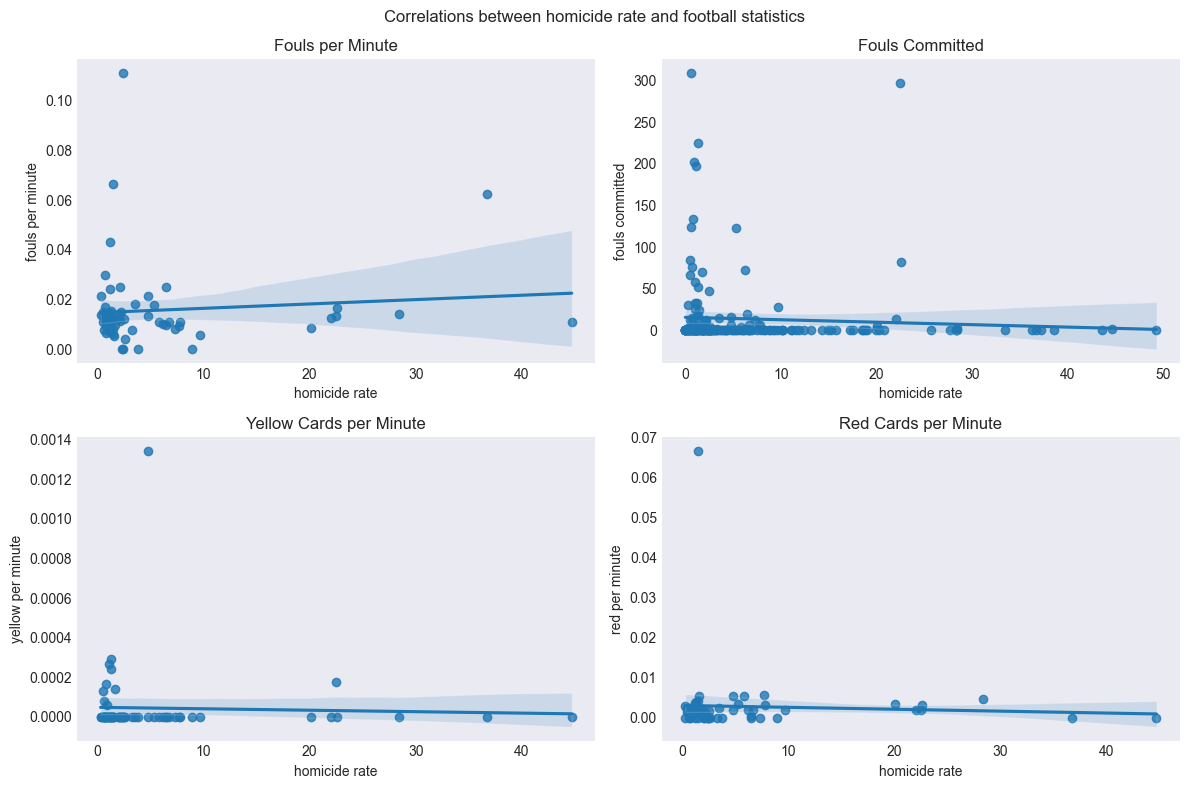

In [8]:
# Calculate the correlation between homicide rate and fouls per minute
correlation_fouls_per_minute = data_agg['homicide rate'].corr(data_agg['fouls per minute'])

# Calculate the correlation between homicide rate and fouls
correlation_fouls = data_agg['homicide rate'].corr(data_agg['fouls committed'])

# Calculate the correlation between homicide rate and yellow cards per minute
correlation_yellow_per_minute = data_agg['homicide rate'].corr(data_agg['yellow per minute'])

# Calculate the correlation between homicide rate and red cards per minute
correlation_red_per_minute = data_agg['homicide rate'].corr(data_agg['red per minute'])

# Print the correlation coefficients
print("Correlation between homicide rate and fouls per minute:", round(correlation_fouls_per_minute, 5))
print("Correlation between homicide rate and fouls:", round(correlation_fouls, 5))
print("Correlation between homicide rate and yellow cards per minute:", round(correlation_yellow_per_minute, 5))
print("Correlation between homicide rate and red cards per minute:", round(correlation_red_per_minute, 5))

import seaborn as sns
import matplotlib.pyplot as plt

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Correlations between homicide rate and football statistics")

# Scatter plot and trendline for the correlation between homicide rate and fouls per minute
sns.regplot(ax=axes[0, 0], x='homicide rate', y='fouls per minute', data=data_agg)
axes[0, 0].set_title("Fouls per Minute")

# Scatter plot and trendline for the correlation between homicide rate and fouls
sns.regplot(ax=axes[0, 1], x='homicide rate', y='fouls committed', data=data_agg)
axes[0, 1].set_title("Fouls Committed")

# Scatter plot and trendline for the correlation between homicide rate and yellow cards per minute
sns.regplot(ax=axes[1, 0], x='homicide rate', y='yellow per minute', data=data_agg)
axes[1, 0].set_title("Yellow Cards per Minute")

# Scatter plot and trendline for the correlation between homicide rate and red cards per minute
sns.regplot(ax=axes[1, 1], x='homicide rate', y='red per minute', data=data_agg)
axes[1, 1].set_title("Red Cards per Minute")

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.show()


## In conclusion this project was aimed at testing the correlation between the homicide -rate of a country and the fouls committed by football players originating from that country. After the data-analysis the results indicate that there is no significant correlation between the homicide-rate and players' fairness on the pitch. The correlations between homicide-rate and fouls per minute, fouls committed in general, yellow and red cards received per minute were all negligibly small.